This is the third and final  Notebook used in this assignment that exclusively focusses model trainnig based on  incorporating temporal, sentimental features in addition to existing product and review data available in the fetched Dataset.

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')


from google.colab import drive
import os

drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/CS6140_MidTerm')

print("Working Directory : ", os.getcwd())

# Setting up Directories to download and store relevant files in respectiev directories
PROJECT_DIR = Path('/content/drive/MyDrive/CS6140_MidTerm')
RAW_DATA_DIR = PROJECT_DIR / 'Data' / 'Raw'
PROCESSED_DATA_DIR = PROJECT_DIR / 'Data' / 'Processed'

# Creating Directories if they do not exist
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)


# Loading Final Model Data for Training
os.chdir(PROCESSED_DATA_DIR)

product_df = pd.read_csv('final_dataset.csv')

Mounted at /content/drive
Working Directory :  /content/drive/MyDrive/CS6140_MidTerm


In [2]:
product_df['Label'].value_counts()

,count
Label,
Unsuccessful,106664
Niche,4887
High Engagement,1817


Question 3 : Training and testing process,
a. From categories of Classification supervised learning, Regression supervised learning
or unsupervised learning, select three models,
b. Develop these three models, using proper parameters
c. What does these parameters mean? What values you set?
d. Any prediction?



Since this project is supervised classification problem I will be using 3 models ,
Logistic Regression (Linear Model)
Random Forest (Ensemble - Bagging)
XGBoost (Ensemble - Boosting).


Reason behind choosing them
1. Logistic Regressio : Faster trainining, provides a baseline performance and works well with scaled features. Scaled X features just for this model for the rest gave X as it is.

2. Random Forest : handles non linear relationships, robust to outliers, minimal hyperparameter tuning requirement. it also naturally handles skewed features andis resitant to overfitting. Since the dataset has tempooral and rating based features felt this could be a better choice also was used in reference project mentioned in report.

3. XGBoost : efficient in computation, can set up to run / build trees parallely, handles imbalnaced data with scale_pos_weight (data is extremely skewed).


before training removed asin because it was just an identifier and also remove Label , focussed on only predicting product success.

X had remaining features and y retained is successful feature

Train and test split was 80% and 20% and was stratified because of class imbalance, using random split could have cuased unrepresentative test set.


Features in X were scaled only for Log Regression because it cannot work with absolutuie values


Setup 5 - fold Cross validation step with Stratified K-Fold and F1 metric as primary to balanve precision and recall for imbalanced dataset.

In [3]:
# Since Label can leak data to the model training , we will first predict if model is successful

training_df = product_df.drop(columns=['Label']).copy()

training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113368 entries, 0 to 113367
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   asin                        113368 non-null  object 
 1   is_successful               113368 non-null  int64  
 2   early_momentum_pct          113368 non-null  float64
 3   std_rating                  113368 non-null  float64
 4   median_rating               113368 non-null  float64
 5   pct_detailed_reviews        113368 non-null  float64
 6   std_sentiment               113368 non-null  float64
 7   max_sentiment               113368 non-null  float64
 8   sentiment_range             113368 non-null  float64
 9   lifetime_avg_rating         113368 non-null  float64
 10  category_All Beauty         113368 non-null  bool   
 11  category_Premium Beauty     113368 non-null  bool   
 12  store_Unknown               113368 non-null  bool   
 13  rating_early_v

In [4]:
training_df.shape

(113368, 26)

In [5]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# Preprocessing and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)


In [19]:
# Data Preparation

# Droping asin - it is a product identifier , not a feature
X = training_df.drop(columns=['asin', 'is_successful'])
y = training_df['is_successful']

print(f"Initial shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())
print(f"Success rate: {y.mean():.4f}")

Initial shape: (113368, 24)
Target distribution:
is_successful
0    106664
1      6704
Name: count, dtype: int64
Success rate: 0.0591


In [20]:
# Converting boolean columns in X to int

bool_cols = X.select_dtypes(include=['bool']).columns

X[bool_cols] = X[bool_cols].astype(int)
print(f"Converted {len(bool_cols)} boolean columns to integers")

Converted 3 boolean columns to integers


In [21]:
#Verifying is there are any other datatypes except numerical in the Training Data
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113368 entries, 0 to 113367
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   early_momentum_pct          113368 non-null  float64
 1   std_rating                  113368 non-null  float64
 2   median_rating               113368 non-null  float64
 3   pct_detailed_reviews        113368 non-null  float64
 4   std_sentiment               113368 non-null  float64
 5   max_sentiment               113368 non-null  float64
 6   sentiment_range             113368 non-null  float64
 7   lifetime_avg_rating         113368 non-null  float64
 8   category_All Beauty         113368 non-null  int64  
 9   category_Premium Beauty     113368 non-null  int64  
 10  store_Unknown               113368 non-null  int64  
 11  rating_early_vs_lifetime    113368 non-null  float64
 12  lg_lifetime_reviews         113368 non-null  float64
 13  log_week1_revi

In [22]:
print(f"\nFinal feature set: {X.shape[1]} features")
print(f"Total samples: {len(X):,}")


Final feature set: 24 features
Total samples: 113,368


In [23]:
# splitting into Train and Test sets
# Stratifying the classes to ensure class balance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"Train success rate: {y_train.mean():.4f}")
print(f"Test success rate: {y_test.mean():.4f}")

Training set: 90,694 samples
Test set: 22,674 samples
Train success rate: 0.0591
Test success rate: 0.0591


In [24]:
# Scaling the values for models - Logisatic Regression
# using Standard Scaler() because there are some log transformed features which have outliers handled through log transform

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Features scaled for Logitic Regression')

Features scaled for Logitic Regression


In [25]:
cv_folds = 5
skf_5 = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
print(f"Using {cv_folds} - fold cross-validation")

Using 5 - fold cross-validation


In [26]:
# Model Training

models = {}
results = {}
training_times = {}

In [27]:
# Logistic Regression
import time
start_time = time.time()

lr_model = LogisticRegression(random_state=42, n_jobs = -1)


print("Training Logistic Regression....")
lr_model.fit(X_train_scaled, y_train)

# trained lr with default parameters to apply l2 regression to prevent overfitting, max iteration of 100 for convergence, and without class balancing to check how the base model classifies successful products

# Cross Validation - using F1 as primary metric to detect successful products
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=skf_5, scoring='f1', n_jobs=-1)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)


training_time_lr = time.time() - start_time

models['Logistic Regression'] = lr_model
training_times['Logistic Regression'] = training_time_lr
results['Logistic Regression'] = {
    'accuracy': accuracy_lr,
    'precision': precision_lr,
    'recall': recall_lr,
    'f1': f1_lr,
    'roc_auc': roc_auc_lr,
    'cv_f1_mean': cv_scores.mean(),
    'cv_f1_std': cv_scores.std(),
    'y_pred': y_pred_lr,
    'y_pred_proba': y_pred_proba_lr
}


# Printing Validatuon Metrics
print("Validation Metrics:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")
print(f"ROC AUC: {roc_auc_lr:.4f}")
print(f"Cross-Validation F1 Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Training Time : {training_time_lr:.2f} seconds")

print("Confusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)

Training Logistic Regression....
Validation Metrics:
Accuracy: 0.9876
Precision: 0.9046
Recall: 0.8837
F1 Score: 0.8940
ROC AUC: 0.9967
Cross-Validation F1 Mean: 0.9005 (+/- 0.0052)
Training Time : 5.65 seconds
Confusion Matrix:
[[21208   125]
 [  156  1185]]


In [28]:
# 2. Random Forest

start_time = time.time()

rf_model = RandomForestClassifier(random_state=42, n_jobs = -1)

print("Training Random Forest with parallel processing....")
rf_model.fit(X_train, y_train)

# Set random forest to run on default parameters with no class_weight such that model balances the classes, and no set depth such that trees grow and stop at ideal depth for classifying

#Cross validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=skf_5, scoring='f1', n_jobs=-1)

#Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

#Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

training_time_rf = time.time() - start_time

models['Random Forest'] = rf_model
training_times['Random Forest'] = training_time_rf
results['Random Forest'] = {
    'accuracy': accuracy_rf,
    'precision': precision_rf,
    'recall': recall_rf,
    'f1': f1_rf,
    'roc_auc': roc_auc_rf,
    'cv_f1_mean': cv_scores.mean(),
    'cv_f1_std': cv_scores.std(),
    'y_pred': y_pred_rf,
    'y_pred_proba': y_pred_proba_rf
}


# Print Validation Metrics
print("Validation Metrics:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"ROC AUC: {roc_auc_rf:.4f}")
print(f"Cross-Validation F1 Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Training Time : {training_time_rf:.2f} seconds")

print("Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

Training Random Forest with parallel processing....
Validation Metrics:
Accuracy: 0.9986
Precision: 0.9895
Recall: 0.9866
F1 Score: 0.9881
ROC AUC: 1.0000
Cross-Validation F1 Mean: 0.9912 (+/- 0.0012)
Training Time : 23.63 seconds
Confusion Matrix:
[[21319    14]
 [   18  1323]]


In [29]:
# Printing the Feature Importance from Random Forest
print(f"\nTop 10 Feature Importances:")
feature_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)
for idx, row in feature_imp.iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")


Top 10 Feature Importances:
  log_count_5_star              : 0.2972
  std_rating                    : 0.2007
  log_reviews_per_week          : 0.1461
  early_momentum_pct            : 0.0597
  median_rating                 : 0.0404
  rating_early_vs_lifetime      : 0.0389
  std_sentiment                 : 0.0320
  log_count_1_star              : 0.0292
  sentiment_range               : 0.0208
  log_week2_4_reviews           : 0.0194


In [30]:
# Training with XGBoost -
# It builds trees sequentially, where each new tree focusses on fixing errors of the previous ones.
# This helps the model learn complex boludaries and adapt to class imbalance

# Calculating scale_pos_weight to assist with class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Training the model with XGBoost
print("Training XGBoost with parallel processing....")

start_time = time.time()

xgb_model = XGBClassifier(random_state=42, n_jobs = -1, scale_pos_weight=scale_pos_weight)
# set up the algorithm with class imbalance using scale_pos_weight feature and set it up to use up CPU to paralelly process building trees for fatser output

print(f"Scale pos weight for class balance: {scale_pos_weight:.2f}")

xgb_model.fit(X_train, y_train)

# Cross validation
print("Performing 5-fold cross-validation...")
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=skf_5, scoring='f1', n_jobs=-1)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

training_time_xgb = time.time() - start_time

models['XGBoost'] = xgb_model
training_times['XGBoost'] = training_time_xgb
results['XGBoost'] = {
    'accuracy': accuracy_xgb,
    'precision': precision_xgb,
    'recall': recall_xgb,
    'f1': f1_xgb,
    'roc_auc': roc_auc_xgb,
    'cv_f1_mean': cv_scores.mean(),
    'cv_f1_std': cv_scores.std(),
    'y_pred': y_pred_xgb,
    'y_pred_proba': y_pred_proba_xgb
}


# Print Validation Metrics
print("Validation Metrics:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"ROC AUC: {roc_auc_xgb:.4f}")
print(f"Cross-Validation F1 Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Training Time : {training_time_xgb:.2f} seconds")

print("Confusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(cm_xgb)


Training XGBoost with parallel processing....
Scale pos weight for class balance: 15.91
Performing 5-fold cross-validation...
Validation Metrics:
Accuracy: 0.9993
Precision: 0.9875
Recall: 1.0000
F1 Score: 0.9937
ROC AUC: 1.0000
Cross-Validation F1 Mean: 0.9938 (+/- 0.0018)
Training Time : 4.14 seconds
Confusion Matrix:
[[21316    17]
 [    0  1341]]


Question 5 :  What metrics you used?
a. Compare the performance of your three models in terms of these metrics,
b. Did you deal with any overfitting/underfitting issues
i. If yes, how did you solve it?
c. Did you use any regularization approach?


In [31]:
# Model Comparison

print("Model Comparison:")

comparison_data = []
for model_name, metrics in results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1'],
        'ROC AUC': metrics['roc_auc'],
        'CV F1 Mean': metrics['cv_f1_mean'],
        'CV F1 Std': metrics['cv_f1_std'],
        'Training Time (s)': training_times[model_name]
    })

comparison_df = pd.DataFrame(comparison_data)

print(comparison_df.to_string(index=False))


best_model_name = comparison_df.loc[comparison_df['CV F1 Mean'].idxmax()]['Model'] # Returning the row index with the best F1 score
best_f1 = comparison_df['F1 Score'].max()

print(f"\nBest Model: {best_model_name} (F1 = {best_f1:.4f})")

Model Comparison:
              Model  Accuracy  Precision   Recall  F1 Score  ROC AUC  CV F1 Mean  CV F1 Std  Training Time (s)
Logistic Regression  0.987607   0.904580 0.883669  0.894002 0.996708    0.900453   0.005210           5.651439
      Random Forest  0.998589   0.989529 0.986577  0.988051 0.999972    0.991229   0.001189          23.632590
            XGBoost  0.999250   0.987482 1.000000  0.993701 0.999997    0.993782   0.001831           4.138847

Best Model: XGBoost (F1 = 0.9937)


In [ ]:
'''
The metrics used in this project is F1 score and Recall score. Since the minority successful class was imbalanced (1 success for every 16 unsucessful product), f1 was necesary to check if
classes were properly identified for products during testing. Further, given that finding all/majority of  Successful products is essential for business perspective (esential to find all successful product to plan inventory management)
recall was also used to compare models

5a. The performance of all the models were compared using a table above, where XGBoost turned out to be the model with teh best accuracy scores.
        F1 - score : 0.9937, Recall : 1.00 '''

'''
5b. There seemed to be issue with overfitting with the models given that accuracy metrics are really high for accuracy scores amd for XGboost base model the recall was perfect at 1.0.
to handle or check for overfitting, I tested if there was any data leakage between values in features captured in the dataset and if any feature had a really high feature importance. Both the
random forest and XGBoost model had excellent generalization evident from cross validation scores and less overfitting. Once I realized there was no overfitting i tried to find it there was any
data leakage. One feature had an importance of 0.5 a really high value, that models would have used that feature combined with the rest feature and importances
to predict very closely along the success metrics defined earlier. Hence to ensure that the model doesnt leverage that feature to predict to a higher accuracy, I ensured to pass only
features that represent the data collected from first month of launch and provided to the XgBoost modle to see if it will be able to predict success at the end of 90 days.
'''


'''

5c. Yes Regulrization approaches were used with all 3 models. the regularization metrics applied to all 3 models are the methods that are applied by default in the models.
In Linerar Regression L2 regression was applied to avoid nay overfitting in the data. With Random Forest Ensemble regularization helped the model to avoid overfitting despite really deep trees (no max depth
was specified). XGBoost uses both L1 and L2 regularization, to which values were also provided during hyper parameter tuning ,where L1 assists with feature selection by allowing sparse weights for features
and L2 ensures that a single feature has a extreme weight associated with it to produce smooth predictions. These regularizations helped the 3 models generated above to prevent any overfitting conditions,
while appropriately figuring out the success metric defined during Data Preparation.

'''

In [ ]:
# All the models gave almost a good set of balanced accuracy metrics with XGboost having the best F1 and Recall at 1.00 highlighting it identified all the successful
# products which is needed for the project.
# Since the acuracy scores for all three models are on the higher side I decided to check for any data leaks in the dataset

In [32]:
 # Since the F1 score is very close to 1.0 testing for any leakage in data, that the model picks up to determine success

 # Check correlation with target

training_data = training_df.drop(columns=['asin'])
print("Feature correlation with is_successful:")
correlations = training_data.corr()['is_successful'].sort_values(ascending=False)
print(correlations.head(10))
print("\n")
print(correlations.tail(5))

Feature correlation with is_successful:
is_successful           1.000000
log_count_5_star        0.551773
log_reviews_per_week    0.488660
log_week2_4_reviews     0.408522
log_month3_reviews      0.384271
log_week1_reviews       0.342233
lg_lifetime_reviews     0.260297
log_count_4_star        0.191861
sentiment_range         0.191164
median_rating           0.182500
Name: is_successful, dtype: float64


log_verified_purchase_mean   -0.069395
std_sentiment                -0.130448
rating_early_vs_lifetime     -0.143467
std_rating                   -0.217789
early_momentum_pct           -0.408016
Name: is_successful, dtype: float64


In [33]:
# Check if any feature is clearly seperable where there are gaps between successful and unsuccessful data
for col in X.columns:

  successful_vals = X[y == 1][col]
  unsuccessful_vals = X[y == 0][col]

  # Check separation
  if successful_vals.min() > unsuccessful_vals.max():  #Checking if successful min value is clearly separable from the highest value of unsuccessful feature value.
    print(f"LEAKAGE WARNING: {col} completely separates classes!")
    print(f"  Successful min: {successful_vals.min():.4f}")
    print(f"  Unsuccessful max: {unsuccessful_vals.max():.4f}")

  else:
    print(f"No leakage warning for {col}")

No leakage warning for early_momentum_pct
No leakage warning for std_rating
No leakage warning for median_rating
No leakage warning for pct_detailed_reviews
No leakage warning for std_sentiment
No leakage warning for max_sentiment
No leakage warning for sentiment_range
No leakage warning for lifetime_avg_rating
No leakage warning for category_All Beauty
No leakage warning for category_Premium Beauty
No leakage warning for store_Unknown
No leakage warning for rating_early_vs_lifetime
No leakage warning for lg_lifetime_reviews
No leakage warning for log_week1_reviews
No leakage warning for log_week2_4_reviews
No leakage warning for log_month3_reviews
No leakage warning for log_reviews_per_week
No leakage warning for log_count_1_star
No leakage warning for log_count_4_star
No leakage warning for log_count_5_star
No leakage warning for log_verified_purchase_mean
No leakage warning for log_avg_review_length
No leakage warning for pct_4_star_w95
No leakage warning for store_encoded


In [ ]:
# it can be seen that log_count_5_star has a really high correlation with the target followed by log_reviews_per_week.
# the availability of the metric from overall reviews could cause the model to utilize this loop hole to easily classify products

In [34]:
# Since there are no leakages in our dataset, there could be leaks from temporal features that feed the successmetric to model
# Duing trainimg. These can include features like 'lg_lifetime_reviews', 'lifetime_avg_rating', 'rating_early_vs_lifetime'
# Dropping these features because they are beyong teh 90 day window perod focus in the project.

# Dropping values that could bias the model from collective count and feeding it with trajectory signals from 90 days

drop_columms = ['lg_lifetime_reviews', 'lifetime_avg_rating', 'rating_early_vs_lifetime', 'log_count_5_star', 'log_count_4_star', 'log_reviews_per_week']
updated_training_df = training_df.drop(columns=drop_columms)

In [35]:
updated_training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113368 entries, 0 to 113367
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   asin                        113368 non-null  object 
 1   is_successful               113368 non-null  int64  
 2   early_momentum_pct          113368 non-null  float64
 3   std_rating                  113368 non-null  float64
 4   median_rating               113368 non-null  float64
 5   pct_detailed_reviews        113368 non-null  float64
 6   std_sentiment               113368 non-null  float64
 7   max_sentiment               113368 non-null  float64
 8   sentiment_range             113368 non-null  float64
 9   category_All Beauty         113368 non-null  bool   
 10  category_Premium Beauty     113368 non-null  bool   
 11  store_Unknown               113368 non-null  bool   
 12  log_week1_reviews           113368 non-null  float64
 13  log_week2_4_re

In [36]:
up_X = updated_training_df.drop(columns=['asin', 'is_successful'])
up_y = updated_training_df['is_successful']

In [37]:
up_X[bool_cols] = X[bool_cols].astype(int)
print(f"Converted {len(bool_cols)} boolean columns to integers")

Converted 3 boolean columns to integers


In [38]:
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(
    up_X, up_y, test_size=0.2, random_state=42, stratify=up_y
)

In [39]:
# Will be using XgBoost beacuse it gave the best recall when trained over the entire 90 day period
# Calculating scale_pos_weight to assist with class imbalance
scale_pos_weight_up = y_train_up.value_counts()[0] / y_train_up.value_counts()[1]

In [40]:
xgb_v1 = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight_up) # Seting with same default parameters to check the accuracy
# Did not use cross validation to just check for accuracy of the model and if the feature list does not have a single or couple features that contribute to predict success.
xgb_v1.fit(X_train_up, y_train_up)
y_pred_v1 = xgb_v1.predict(X_test_up)

acc_up = accuracy_score(y_test_up, y_pred_v1)
f1_up = f1_score(y_test_up, y_pred_v1)

print(f"\nResults:")
print(f"  Accuracy:  {acc_up:.4f}")
print(f"  F1 Score:  {f1_up:.4f}")



Results:
  Accuracy:  0.9983
  F1 Score:  0.9859


In [41]:
# Planning on testing the model to predict if product will be sucessful at the end of 90 days window from launch based on initial 4 weeks of reviews

early_feature =[
    'log_week1_reviews',
    'log_week2_4_reviews',  # Stop at day 28
    'early_momentum_pct',
    'std_rating',
    'median_rating',
    'pct_detailed_reviews',
    'std_sentiment',
    'max_sentiment',
    'sentiment_range',
    'log_verified_purchase_mean',
    'log_avg_review_length',
    'store_encoded',
    'store_Unknown',
    'category_All Beauty',
    'category_Premium Beauty'

]

X_early = training_df[early_feature]
y_early = training_df['is_successful']

In [42]:
X_early.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113368 entries, 0 to 113367
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   log_week1_reviews           113368 non-null  float64
 1   log_week2_4_reviews         113368 non-null  float64
 2   early_momentum_pct          113368 non-null  float64
 3   std_rating                  113368 non-null  float64
 4   median_rating               113368 non-null  float64
 5   pct_detailed_reviews        113368 non-null  float64
 6   std_sentiment               113368 non-null  float64
 7   max_sentiment               113368 non-null  float64
 8   sentiment_range             113368 non-null  float64
 9   log_verified_purchase_mean  113368 non-null  float64
 10  log_avg_review_length       113368 non-null  float64
 11  store_encoded               113368 non-null  float64
 12  store_Unknown               113368 non-null  bool   
 13  category_All B

In [43]:
X_early[bool_cols] = X[bool_cols].astype(int)
print(f"Converted {len(bool_cols)} boolean columns to integers")

Converted 3 boolean columns to integers


In [44]:
X_train_early, X_test_early, y_train_early, y_test_early = train_test_split(
    X_early, y_early, test_size=0.2, random_state=42, stratify=y_early
)
print(f"Training set: {len(X_train_early):,} samples")
print(f"Test set: {len(X_test_early):,} samples")
print(f"Train success rate: {y_train_early.mean():.4f}")
print(f"Test success rate: {y_test_early.mean():.4f}")

Training set: 90,694 samples
Test set: 22,674 samples
Train success rate: 0.0591
Test success rate: 0.0591


In [45]:
# Calculating scale_pos_weight to assist with class imbalance
scale_pos_weight = y_train_early.value_counts()[0] / y_train_early.value_counts()[1]

# Training the model with XGBoost
print("Training XGBoost with parallel processing....")

start_time = time.time()

xgb_early_model = XGBClassifier(random_state=42, n_jobs = -1, scale_pos_weight=scale_pos_weight)

print(f"Scale pos weight for class balance: {scale_pos_weight:.2f}")

xgb_early_model.fit(X_train_early, y_train_early)

# Cross validation
print("Performing 5-fold cross-validation...")
cv_scores = cross_val_score(xgb_early_model, X_train_early, y_train_early, cv=skf_5, scoring='f1', n_jobs=-1)

# Predictions
y_pred_xgb_early = xgb_early_model.predict(X_test_early)
y_pred_proba_xgb_early = xgb_early_model.predict_proba(X_test_early)[:, 1]

# Calculate metrics
accuracy_xgb_early = accuracy_score(y_test_early, y_pred_xgb_early)
precision_xgb_early = precision_score(y_test_early, y_pred_xgb_early)
recall_xgb_early = recall_score(y_test_early, y_pred_xgb_early)
f1_xgb_early = f1_score(y_test_early, y_pred_xgb_early)
roc_auc_xgb_early = roc_auc_score(y_test_early, y_pred_proba_xgb_early)

training_time_xgb_early = time.time() - start_time

models['XGBoost-Early'] = xgb_early_model
training_times['XGBoost'] = training_time_xgb_early
results['XGBoost'] = {
    'accuracy': accuracy_xgb_early,
    'precision': precision_xgb_early,
    'recall': recall_xgb_early,
    'f1': f1_xgb_early,
    'roc_auc': roc_auc_xgb_early,
    'cv_f1_mean': cv_scores.mean(),
    'cv_f1_std': cv_scores.std(),
    'y_pred': y_pred_xgb_early,
    'y_pred_proba': y_pred_proba_xgb_early
}


# Print Validation Metrics
print("Validation Metrics:")
print(f"Accuracy: {accuracy_xgb_early:.4f}")
print(f"Precision: {precision_xgb_early:.4f}")
print(f"Recall: {recall_xgb_early:.4f}")
print(f"F1 Score: {f1_xgb_early:.4f}")
print(f"ROC AUC: {roc_auc_xgb_early:.4f}")
print(f"Cross-Validation F1 Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Training Time : {training_time_xgb_early:.2f} seconds")

print("Confusion Matrix:")
cm_xgb = confusion_matrix(y_test_early, y_pred_xgb_early)
print(cm_xgb)

Training XGBoost with parallel processing....
Scale pos weight for class balance: 15.91
Performing 5-fold cross-validation...
Validation Metrics:
Accuracy: 0.9978
Precision: 0.9694
Recall: 0.9933
F1 Score: 0.9812
ROC AUC: 0.9999
Cross-Validation F1 Mean: 0.9818 (+/- 0.0021)
Training Time : 4.92 seconds
Confusion Matrix:
[[21291    42]
 [    9  1332]]


In [46]:
# Defining minimal early features - only volume patterns and context
minimal_early_features = [
    'log_week1_reviews',
    'log_week2_4_reviews',
    'log_reviews_per_week',
    'early_momentum_pct',  # Ratio, not absolute values
    'store_encoded',
    'store_Unknown',
    'category_All Beauty',
    'category_Premium Beauty'
]

print(f"\nFeatures used: {len(minimal_early_features)}")
for feat in minimal_early_features:
    print(f"  - {feat}")

# Prepare data
X_minimal = training_df[minimal_early_features].copy()
y_minimal = training_df['is_successful']

# Convert boolean columns to integers
bool_cols = X_minimal.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    X_minimal[bool_cols] = X_minimal[bool_cols].astype(int)
    print(f"\nConverted {len(bool_cols)} boolean columns to integers")

# Train-test split with stratification
X_train_minimal, X_test_minimal, y_train_minimal, y_test_minimal = train_test_split(
    X_minimal, y_minimal, test_size=0.2, random_state=42, stratify=y_minimal
)

print(f"\nTrain-Test Split:")
print(f"  Training samples: {len(X_train_minimal):,}")
print(f"  Test samples: {len(X_test_minimal):,}")
print(f"  Success rate in train: {y_train_minimal.mean():.4f}")
print(f"  Success rate in test: {y_test_minimal.mean():.4f}")

# Calculate scale_pos_weight to assist with class imbalance
scale_pos_weight_minimal = y_train_minimal.value_counts()[0] / y_train_minimal.value_counts()[1]

# Setup cross-validation
skf_minimal = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training the model with XGBoost

print("Training XGBoost with parallel processing...")

start_time = time.time()

xgb_minimal_model = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight_minimal,
    verbosity=0
)

print(f"Scale pos weight for class balance: {scale_pos_weight_minimal:.2f}")
xgb_minimal_model.fit(X_train_minimal, y_train_minimal)

# Cross validation
print("Performing 5-fold cross-validation...")
cv_scores_minimal = cross_val_score(
    xgb_minimal_model,
    X_train_minimal,
    y_train_minimal,
    cv=skf_minimal,
    scoring='f1',
    n_jobs=-1
)

# Predictions
y_pred_xgb_minimal = xgb_minimal_model.predict(X_test_minimal)
y_pred_proba_xgb_minimal = xgb_minimal_model.predict_proba(X_test_minimal)[:, 1]

# Calculate metrics
accuracy_xgb_minimal = accuracy_score(y_test_minimal, y_pred_xgb_minimal)
precision_xgb_minimal = precision_score(y_test_minimal, y_pred_xgb_minimal)
recall_xgb_minimal = recall_score(y_test_minimal, y_pred_xgb_minimal)
f1_xgb_minimal = f1_score(y_test_minimal, y_pred_xgb_minimal)
roc_auc_xgb_minimal = roc_auc_score(y_test_minimal, y_pred_proba_xgb_minimal)

training_time_xgb_minimal = time.time() - start_time

# Store results
models['XGBoost-Minimal-Early'] = xgb_minimal_model
training_times['XGBoost-Minimal-Early'] = training_time_xgb_minimal
results['XGBoost-Minimal-Early'] = {
    'accuracy': accuracy_xgb_minimal,
    'precision': precision_xgb_minimal,
    'recall': recall_xgb_minimal,
    'f1': f1_xgb_minimal,
    'roc_auc': roc_auc_xgb_minimal,
    'cv_f1_mean': cv_scores_minimal.mean(),
    'cv_f1_std': cv_scores_minimal.std(),
    'y_pred': y_pred_xgb_minimal,
    'y_pred_proba': y_pred_proba_xgb_minimal
}

# Print Validation Metrics

print("VALIDATION METRICS")

print(f"Accuracy:  {accuracy_xgb_minimal:.4f}")
print(f"Precision: {precision_xgb_minimal:.4f}")
print(f"Recall:    {recall_xgb_minimal:.4f}")
print(f"F1 Score:  {f1_xgb_minimal:.4f}")
print(f"ROC AUC:   {roc_auc_xgb_minimal:.4f}")
print(f"\nCross-Validation F1: {cv_scores_minimal.mean():.4f} (+/- {cv_scores_minimal.std():.4f})")
print(f"Training Time: {training_time_xgb_minimal:.2f} seconds")

print("\nConfusion Matrix:")
cm_xgb_minimal = confusion_matrix(y_test_minimal, y_pred_xgb_minimal)
print(cm_xgb_minimal)


Features used: 8
  - log_week1_reviews
  - log_week2_4_reviews
  - log_reviews_per_week
  - early_momentum_pct
  - store_encoded
  - store_Unknown
  - category_All Beauty
  - category_Premium Beauty

Converted 3 boolean columns to integers

Train-Test Split:
  Training samples: 90,694
  Test samples: 22,674
  Success rate in train: 0.0591
  Success rate in test: 0.0591
Training XGBoost with parallel processing...
Scale pos weight for class balance: 15.91
Performing 5-fold cross-validation...
VALIDATION METRICS
Accuracy:  0.8786
Precision: 0.3267
Recall:    0.9918
F1 Score:  0.4915
ROC AUC:   0.9518

Cross-Validation F1: 0.4850 (+/- 0.0040)
Training Time: 1.69 seconds

Confusion Matrix:
[[18592  2741]
 [   11  1330]]


Question 4 : Select proper hyper parameter tuning technique, and what is the best parameters for models,
a. Define the technique you used


for hyperparameter tuning on the updated det of model training with selected features I used RandomizedSearchCV that samples a fixed number of parameter combinations uisng cross-validation. Unlike Grid Search which exhaustively searches along all combinations, this randomly samples from parameter space, making it efficient for lareg parameter space.


The parameter space can be a set of discrete values that can be passed manually for each feature giving full control over excact values that can be tested. Or it can also be a continuous distribution where random values can be drawn and ther are no gaps in values. The issue with this can be sampling from poor values if ranges are poorly chosen and can be harder to reproduce the exact configuration.

In [47]:
from sklearn.model_selection import RandomizedSearchCV

print("Hyperparameter Tuning for XGBoost Minimal Early Features")

# Provided manual values to hyper parameter tuning

param_distributions = {
    'n_estimators': [100, 150, 200, 250, 300],   #Setting the number of boosting rounds
    'max_depth': [3, 4, 5, 6, 7, 8],  # maximum depth of each tree
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],     #Fraction of rows sampled for each tree / Prevents overfitting
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # Fraction of features to use when building each tree
    'min_child_weight': [1, 3, 5, 7],    # Prevents creating branches for very few samples
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],    # Minimum threshold to partition a child
    'reg_alpha': [0, 0.01, 0.1, 0.5],    # Performs L1 regularization helping with feature selection and generalization
    'reg_lambda': [1, 1.5, 2, 3]        # Perform L2 regularization, stabilizing large weights

}


# Create base model with class balancing
base_xgb = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight_minimal,
    verbosity=0,
    eval_metric='aucpr'
)

random_search = RandomizedSearchCV(
    estimator=base_xgb,
    param_distributions=param_distributions,
    n_iter=70,
    cv = 5,
    scoring='average_precision',
    n_jobs=-1,
    verbose=0,
    random_state=42,
    return_train_score=True
)

tuning_start = time.time()
# Fit the random search to the data
random_search.fit(X_train_minimal, y_train_minimal)
tuning_time = time.time() - tuning_start

# Get the best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_
best_cv_score = random_search.best_score_

Hyperparameter Tuning for XGBoost Minimal Early Features


In [48]:
best_params

{'subsample': 0.6,
 'reg_lambda': 2,
 'reg_alpha': 0.1,
 'n_estimators': 250,
 'min_child_weight': 7,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 0.2,
 'colsample_bytree': 0.9}

In [49]:
print(f"Time taken for hyper parameter tuning : {tuning_time} s")

Time taken for hyper parameter tuning : 265.4270474910736 s


In [50]:
xgb_tuned_model = best_model

cv_scores_tuned = cross_val_score(
    xgb_tuned_model,
    X_train_minimal,
    y_train_minimal,
    cv=skf_minimal,
    scoring='f1',
    n_jobs = -1
)

y_pred_tuned = xgb_tuned_model.predict(X_test_minimal)
y_pred_proba_tuned = xgb_tuned_model.predict_proba(X_test_minimal)[:, 1]

accuracy_tuned = accuracy_score(y_test_minimal, y_pred_tuned)
precision_tuned = precision_score(y_test_minimal, y_pred_tuned)
recall_tuned = recall_score(y_test_minimal, y_pred_tuned)
f1_tuned = f1_score(y_test_minimal, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test_minimal, y_pred_proba_tuned)

models['XGBoost-Tuned'] = xgb_tuned_model
training_times['XGBoost-Tuned'] = tuning_time
results['XGBoost-Tuned'] = {
    'accuracy': accuracy_tuned,
    'precision': precision_tuned,
    'recall': recall_tuned,
    'f1': f1_tuned,
    'roc_auc': roc_auc_tuned,
    'cv_f1_mean': cv_scores_tuned.mean(),
    'cv_f1_std': cv_scores_tuned.std(),
    'y_pred': y_pred_tuned,
    'y_pred_proba': y_pred_proba_tuned
}

print("VALIDATION METRICS")
print(f"Accuracy:  {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall:    {recall_tuned:.4f}")
print(f"F1 Score:  {f1_tuned:.4f}")
print(f"ROC AUC:   {roc_auc_tuned:.4f}")
print(f"\nCross-Validation F1: {cv_scores_tuned.mean():.4f} (+/- {cv_scores_tuned.std():.4f})")
print(f"Training Time: {tuning_time:.2f} seconds")

print("\nConfusion Matrix:")
cm_xgb_tuned = confusion_matrix(y_test_minimal, y_pred_tuned)
print(cm_xgb_tuned)



VALIDATION METRICS
Accuracy:  0.8781
Precision: 0.3266
Recall:    1.0000
F1 Score:  0.4924
ROC AUC:   0.9541

Cross-Validation F1: 0.4870 (+/- 0.0032)
Training Time: 265.43 seconds

Confusion Matrix:
[[18568  2765]
 [    0  1341]]


In [57]:
#Defining minimal early features - including sentiment features as well
# Removed log _reviews_per_week feature as well thereby giving the model only reviews from first month of reviews
ext_minimal_early_features = [
    'log_week1_reviews',
    'log_week2_4_reviews',
    'early_momentum_pct',  # Ratio, not absolute values
    'max_sentiment',
    'sentiment_range',
    'store_encoded',
    'store_Unknown',
    'category_All Beauty',
    'category_Premium Beauty'
]

print(f"\nFeatures used: {len(ext_minimal_early_features)}")
for feat in minimal_early_features:
    print(f"  - {feat}")

# Prepare data
X_ext_minimal = training_df[ext_minimal_early_features].copy()
y_ext_minimal = training_df['is_successful']

# Convert boolean columns to integers
bool_cols = X_ext_minimal.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    X_ext_minimal[bool_cols] = X_ext_minimal[bool_cols].astype(int)
    print(f"\nConverted {len(bool_cols)} boolean columns to integers")

# Train-test split with stratification
X_train_ext_minimal, X_test_ext_minimal, y_train_ext_minimal, y_test_ext_minimal = train_test_split(
    X_ext_minimal, y_ext_minimal, test_size=0.2, random_state=42, stratify=y_minimal
)

print(f"\nTrain-Test Split:")
print(f"  Training samples: {len(X_train_ext_minimal):,}")
print(f"  Test samples: {len(X_test_ext_minimal):,}")
print(f"  Success rate in train: {y_train_ext_minimal.mean():.4f}")
print(f"  Success rate in test: {y_test_ext_minimal.mean():.4f}")

# Calculate scale_pos_weight to assist with class imbalance
scale_pos_weight_ext_minimal = y_train_ext_minimal.value_counts()[0] / y_train_ext_minimal.value_counts()[1]

# Setup cross-validation
skf_minimal = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training the model with XGBoost

print("Training XGBoost with parallel processing...")

start_time = time.time()

xgb_ext_minimal_model = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight_ext_minimal,
    verbosity=0
)

print(f"Scale pos weight for class balance: {scale_pos_weight_minimal:.2f}")
xgb_ext_minimal_model.fit(X_train_ext_minimal, y_train_ext_minimal)

# Cross validation
print("Performing 5-fold cross-validation...")
cv_scores_minimal = cross_val_score(
    xgb_ext_minimal_model,
    X_train_ext_minimal,
    y_train_ext_minimal,
    cv=skf_minimal,
    scoring='f1',
    n_jobs=-1
)

# Predictions
y_pred_xgb_ext_minimal = xgb_ext_minimal_model.predict(X_test_ext_minimal)
y_pred_proba_xgb_ext_minimal = xgb_ext_minimal_model.predict_proba(X_test_ext_minimal)[:, 1]

# Calculate metrics
accuracy_xgb_minimal = accuracy_score(y_test_ext_minimal, y_pred_xgb_ext_minimal)
precision_xgb_minimal = precision_score(y_test_ext_minimal, y_pred_xgb_ext_minimal)
recall_xgb_minimal = recall_score(y_test_ext_minimal, y_pred_xgb_ext_minimal)
f1_xgb_minimal = f1_score(y_test_ext_minimal, y_pred_xgb_ext_minimal)
roc_auc_xgb_minimal = roc_auc_score(y_test_ext_minimal, y_pred_proba_xgb_ext_minimal)

training_time_xgb_minimal = time.time() - start_time

# Store results
models['XGBoost-Ext-Minimal-Early'] = xgb_ext_minimal_model
training_times['XGBoost-Ext-Minimal-Early'] = training_time_xgb_minimal
results['XGBoost-Ext-Minimal-Early'] = {
    'accuracy': accuracy_xgb_minimal,
    'precision': precision_xgb_minimal,
    'recall': recall_xgb_minimal,
    'f1': f1_xgb_minimal,
    'roc_auc': roc_auc_xgb_minimal,
    'cv_f1_mean': cv_scores_minimal.mean(),
    'cv_f1_std': cv_scores_minimal.std(),
    'y_pred': y_pred_xgb_minimal,
    'y_pred_proba': y_pred_proba_xgb_minimal
}

# Print Validation Metrics

print("VALIDATION METRICS")

print(f"Accuracy:  {accuracy_xgb_minimal:.4f}")
print(f"Precision: {precision_xgb_minimal:.4f}")
print(f"Recall:    {recall_xgb_minimal:.4f}")
print(f"F1 Score:  {f1_xgb_minimal:.4f}")
print(f"ROC AUC:   {roc_auc_xgb_minimal:.4f}")
print(f"\nCross-Validation F1: {cv_scores_minimal.mean():.4f} (+/- {cv_scores_minimal.std():.4f})")
print(f"Training Time: {training_time_xgb_minimal:.2f} seconds")

print("\nConfusion Matrix:")
cm_xgb_ext_minimal = confusion_matrix(y_test_ext_minimal, y_pred_xgb_ext_minimal)
print(cm_xgb_ext_minimal)


Features used: 9
  - log_week1_reviews
  - log_week2_4_reviews
  - log_reviews_per_week
  - early_momentum_pct
  - store_encoded
  - store_Unknown
  - category_All Beauty
  - category_Premium Beauty

Converted 3 boolean columns to integers

Train-Test Split:
  Training samples: 90,694
  Test samples: 22,674
  Success rate in train: 0.0591
  Success rate in test: 0.0591
Training XGBoost with parallel processing...
Scale pos weight for class balance: 15.91
Performing 5-fold cross-validation...
VALIDATION METRICS
Accuracy:  0.9336
Precision: 0.4695
Recall:    0.9463
F1 Score:  0.6276
ROC AUC:   0.9779

Cross-Validation F1: 0.6265 (+/- 0.0033)
Training Time: 4.11 seconds

Confusion Matrix:
[[19899  1434]
 [   72  1269]]


In [52]:
#Hyperparameter tuning the previous model
from scipy.stats import randint, uniform

start_time = time.time()

pos_weight = y_train_ext_minimal.value_counts()[0] / y_train_ext_minimal.value_counts()[1]

xgb_base = XGBClassifier(
    random_state=42,
    n_jobs = -1,
    scasle_pos_weight=pos_weight,
    verbosity=0,
    eval_metric='aucpr'  # Testing with aucpr, found it was better for imbalanced datasets
)


# Providing  uniform values for hyperparameter tuning

param_distributions={
    "n_estimators" : randint(200, 600), #Setting the number of boosting rounds
    "learning_rate": uniform(0.02, 0.08),
    "max_depth": randint(3, 7),       # maximum depth of each tree
    "min_child_weight": randint(2, 8),  # Prevents creating branches for very few samples
    "gamma": uniform(0, 0.3),           # Minimum threshold to partition a child
    "subsample": uniform(0.6, 0.3),    #Fraction of rows sampled for each tree / Prevents overfitting
    "colsample_bytree": uniform(0.6, 0.3), # Fraction of features to use when building each tree
    "reg_alpha": uniform(0, 0.2),  # Performs L1 regularization helping with feature selection and generalization
    "reg_lambda": uniform(1,2),  # Perform L2 regularization, stabilizing large weights
}

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=30,
    cv = skf_minimal,
    scoring='average_precision',
    n_jobs=-1,
    verbose=0,
    random_state=42,
    return_train_score=True
)

random_search.fit(X_train_ext_minimal, y_train_ext_minimal)

tuning_time = time.time() - start_time
print(f"Time taken for hyper parameter tuning : {tuning_time} s")
print("Best params:", random_search.best_params_)
print("Best CV PR-AUC:", random_search.best_score_)
best_xgb = random_search.best_estimator_


Time taken for hyper parameter tuning : 255.360698223114 s
Best params: {'colsample_bytree': np.float64(0.8921266556524377), 'gamma': np.float64(0.06983140212909127), 'learning_rate': np.float64(0.027248514762625665), 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 563, 'reg_alpha': np.float64(0.10284688768272232), 'reg_lambda': np.float64(2.184829137724085), 'subsample': np.float64(0.6139351238159994)}
Best CV PR-AUC: 0.7195290664755687


In [53]:
# Cross validation
print("Performing 5-fold cross-validation...")
cv_scores_minimal = cross_val_score(
    best_xgb,
    X_train_ext_minimal,
    y_train_ext_minimal,
    cv=skf_minimal,
    scoring='f1',
    n_jobs=-1
)

# Predictions
y_pred_hyp_xgb_28 = best_xgb.predict(X_test_ext_minimal)
y_pred_proba_hyp_xgb_28 = best_xgb.predict_proba(X_test_ext_minimal)[:, 1]

# Calculate metrics
accuracy_hyp_xgb_28 = accuracy_score(y_test_ext_minimal, y_pred_hyp_xgb_28)
precision_hyp_xgb_28 = precision_score(y_test_ext_minimal, y_pred_hyp_xgb_28)
recall_hyp_xgb_28 = recall_score(y_test_ext_minimal, y_pred_hyp_xgb_28)
f1_hyp_xgb_28 = f1_score(y_test_ext_minimal, y_pred_hyp_xgb_28)
roc_auc_hyp_xgb_28 = roc_auc_score(y_test_ext_minimal, y_pred_proba_hyp_xgb_28)

training_time_hyp_xgb_28 = tuning_time

# Store results
models['XGBoost-Hyp-28'] = best_xgb
training_times['XGBoost-Hyp-28'] = training_time_hyp_xgb_28
results['XGBoost-Ext-Minimal-Early'] = {
    'accuracy': accuracy_hyp_xgb_28,
    'precision': precision_hyp_xgb_28,
    'recall': recall_hyp_xgb_28,
    'f1': f1_hyp_xgb_28,
    'roc_auc': roc_auc_hyp_xgb_28,
    'cv_f1_mean': cv_scores_minimal.mean(),
    'cv_f1_std': cv_scores_minimal.std(),
    'y_pred': y_pred_hyp_xgb_28,
    'y_pred_proba': y_pred_proba_hyp_xgb_28
}

# Print Validation Metrics

print("VALIDATION METRICS")

print(f"Accuracy:  {accuracy_hyp_xgb_28:.4f}")
print(f"Precision: {precision_hyp_xgb_28:.4f}")
print(f"Recall:    {recall_hyp_xgb_28:.4f}")
print(f"F1 Score:  {f1_hyp_xgb_28:.4f}")
print(f"ROC AUC:   {roc_auc_hyp_xgb_28:.4f}")
print(f"\nCross-Validation F1: {cv_scores_minimal.mean():.4f} (+/- {cv_scores_minimal.std():.4f})")
print(f"Training Time: {training_time_xgb_minimal:.2f} seconds")

print("\nConfusion Matrix:")
cm_xgb_hyp = confusion_matrix(y_test_ext_minimal, y_pred_hyp_xgb_28)
print(cm_xgb_hyp)

Performing 5-fold cross-validation...
VALIDATION METRICS
Accuracy:  0.9588
Precision: 0.6579
Recall:    0.6309
F1 Score:  0.6441
ROC AUC:   0.9800

Cross-Validation F1: 0.6445 (+/- 0.0056)
Training Time: 2.49 seconds

Confusion Matrix:
[[20893   440]
 [  495   846]]


5e. Provide the results without using hyperparameter and with hyper parameter, and compare them?


The results with and without hyperparameter, had a very small increase in f1 score (approximately 2%) , there was a significant difference in the number of False Positives it has reduced from 1434 to 440 products, bust False negatives which is supposed to be lower has hads a significant increase to 440 from 72 which coudl affect businesses. The hyperparameter tuning has helped with stabikizing the model as well where the accuracy, f1 and recall are all closer to each other at 0.63 which had significant gaps prior to tuning, which had  Precision: 0.4695, Recall:    0.9463 and F1 Score:  0.6276, It failed to meet the business target of reduced False Negatives.

In [56]:

print("Training XGBoost with parallel processing...")

start_time = time.time()
pos_weight = y_train_ext_minimal.value_counts()[0] / y_train_ext_minimal.value_counts()[1]

xgb_ext_base = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight_ext_minimal,
    verbosity=0
)

print(f"Scale pos weight for class balance: {pos_weight:.2f}")
xgb_ext_base.fit(X_train_ext_minimal, y_train_ext_minimal)


# Predictions
y_pred_xgb_base = xgb_ext_base.predict(X_test_ext_minimal)
y_pred_proba_xgb_base = xgb_ext_base.predict_proba(X_test_ext_minimal)[:, 1]

# Calculate metrics
accuracy_xgb_base = accuracy_score(y_test_ext_minimal, y_pred_xgb_base)
precision_xgb_base = precision_score(y_test_ext_minimal, y_pred_xgb_base)
recall_xgb_base = recall_score(y_test_ext_minimal, y_pred_xgb_base)
f1_xgb_base = f1_score(y_test_ext_minimal, y_pred_xgb_base)
roc_auc_xgb_base = roc_auc_score(y_test_ext_minimal, y_pred_proba_xgb_base)

training_time_xgb_base = time.time() - start_time

# Store results
models['XGBoost-Base'] = xgb_ext_minimal_model
training_times['XGBoost-Base'] = training_time_xgb_minimal
results['XGBoost-Base'] = {
    'accuracy': accuracy_xgb_base,
    'precision': precision_xgb_base,
    'recall': recall_xgb_base,
    'f1': f1_xgb_base,
    'roc_auc': roc_auc_xgb_base,
    'cv_f1_mean': np.nan,
    'cv_f1_std': np.nan,
    'y_pred': y_pred_xgb_base,
    'y_pred_proba': y_pred_proba_xgb_base
}

# Print Validation Metrics

print("VALIDATION METRICS")

print(f"Accuracy:  {accuracy_xgb_base:.4f}")
print(f"Precision: {precision_xgb_base:.4f}")
print(f"Recall:    {recall_xgb_base:.4f}")
print(f"F1 Score:  {f1_xgb_base:.4f}")
print(f"ROC AUC:   {roc_auc_xgb_base:.4f}")
print(f"Training Time: {training_time_xgb_base:.2f} seconds")

print("\nConfusion Matrix:")
cm_xgb_base = confusion_matrix(y_test_ext_minimal, y_pred_xgb_base)
print(cm_xgb_base)

Training XGBoost with parallel processing...
Scale pos weight for class balance: 15.91
VALIDATION METRICS
Accuracy:  0.9336
Precision: 0.4695
Recall:    0.9463
F1 Score:  0.6276
ROC AUC:   0.9779
Training Time: 1.47 seconds

Confusion Matrix:
[[19899  1434]
 [   72  1269]]


5d. Get the results with cross validation and without cross validation for each model, any
difference? Discuss the method did you use?


Answer : There were no difference observed in accuracy metrics for without cross vallidation for XgBoost model. Though the model with cv had executed in lesser time (1.47s) in comparison to XGBoost with cv (~ 4 s), cross validation ensures that the model does not fall into risk of overfitting on the data making it difficult for it to generalize when it runs on a new set of data. Hence, performing cross validation becomes an essential step during model training to identify any overfitting risk.

Question (6) Analyze the results,
a. What did you learn?
b. Did you find any pattern in your models/data?
c. Provide few key points that you learned from your results.



a. From this project I learnt that data preparation also involves steps to understand the data and add relevant features that could be essential to predict success outcomes. having Domain knowledge helps with Imputation of values and EDA , where I understood not all outliers are bad and need to be removed. Sometimes, outliers help the model to classify good products from failed ones. Even when overfitting is not the case, a simple success metric can be figured out by complex classification models like Random Forest and XGBoost very easily, while ensuring that features that have good feature importance should be passed to models, it should also be judicious with the features that are passed ensuring no strong overall predictors are passed to models based on which models leverage a couple of features to classify labels. I also learnt that investing a good amount of time in feature engineering can assist with higher prediction accuracies for model, however the limit of feature engineering needs to be considered such that dataset is oversimplified for model to pick up on certain key features to predict success.

b. I found that momentum based temporal patterns had a strong feature importance and at the same time were highly collinear with each feature. While building features it is equally important to test if features represent almost identical information instead of leaving it for later in the pipeline. Feature Selection is an iterative process that involves checking for collinearity, weak features exploring if features belonging to different data types share some similarities in values. Eventhough models suggest to drop features that are collinear it is always better to manually check if features that are going to be dropped are essential and statistically significant, similar to removing early_momentum_pct from features that were to be drop on collinearity basis. That was a feature that was statistically significant, dropping it woudl have costed the dataset from losing all review momentum related features because they shared collinearity with rating features that had greater importance in the dataset.


c. From my results I learnt that
  1. Early-momentum indicators derived from review velocity, and sentiment dynamics can predict the eventual success of beauty products.
  2. Beyond sole Statistical accuracies, business friendly approaches needs to be considered when building or considering models for real life scenarios.
  3. Hyperparameter tuning doesnt always necessarily drastically improve model accuracies, it can also stabilize the predictions in comparison to pre-tuned models.


Conclusion

This study demonstrates that early-momentum indicators derived from review velocity, and sentiment dynamics can predict the eventual success of beauty products sold on Amazon. By prioritizing business-driven thresholds and prediction based on early market acceptance indicators, the model delivers actionable early insights, assisting stakeholders with proactive marketing and inventory decisions.

While the results from pre-tuned model is promising, there are several limitations that does provide opportunities for future improvement and broader applicability:

1.	Class Imbalance: The dataset had a significant data imbalance, with only 5.9% of products classified as successful. This constraint explains the limited precision in pre-tuned model. Exploring appropriate resampling techniques to mitigate the imbalance, could help improve on precision and recall of pre-tuned model to match tuned model scores.

2.	Temporal Window: The 28-day observation window captures early momentum effectively but may overlook products that might gradually gain popularity later. Studying to expand the observation window or retraining the model after a certain time threshold could help it understand nuances in the customer purchases and adapt accordingly.


3.	Success Definition: The currently defined two tier success definition simplifies the success definition, which has been captured by model easily explaining the higher accuracy scores when trained on the entire 90-day window dataset. Could consider alternate multi-tier success definition to better capture successful products from all available products in the dataset.

4. Brand Reputation: The top 10 brands that were included in this project had an accumulated total of all products in the dataset. Fig. 4 highlights that most values in store-encoding is 0 (about 100,000+ products), classified as “store_Unknown”. A further study into brand reputations and isolating those brands that have successful and unsuccessful effects among the customer based would be helpful to increase the coverage of brand reputation above 2% of dataset and incorporate reputation signals into training the model.  (Given in the plot below).



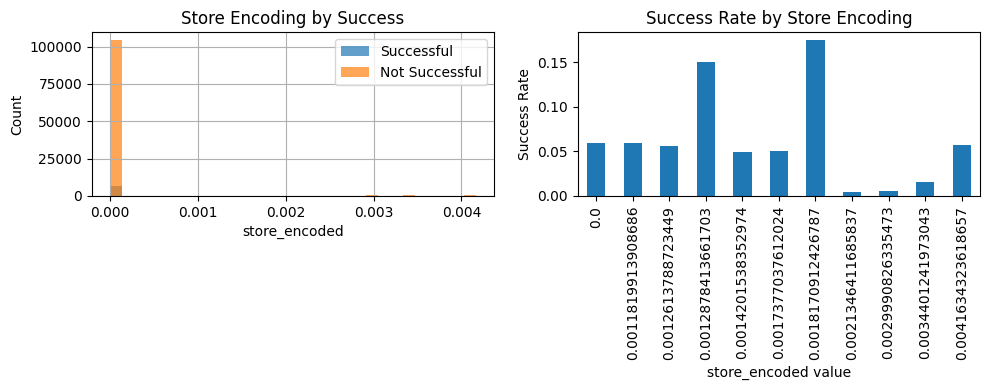

Success rates by store_encoded value:
                   mean   count
store_encoded                  
0.001817       0.174757     206
0.001288       0.150685     146
0.001182       0.059701     134
0.000000       0.059277  110937
0.004163       0.057203     472
0.001261       0.055944     143
0.001738       0.050761     197
0.001420       0.049689     161
0.003440       0.015385     390
0.002999       0.005882     340
0.002135       0.004132     242


In [58]:
import matplotlib.pyplot as plt

# Plot store_encoded distribution by success
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
product_df[product_df['is_successful'] == 1]['store_encoded'].hist(bins=30, alpha=0.7, label='Successful')
product_df[product_df['is_successful'] == 0]['store_encoded'].hist(bins=30, alpha=0.7, label='Not Successful')
plt.xlabel('store_encoded')
plt.ylabel('Count')
plt.legend()
plt.title('Store Encoding by Success')

plt.subplot(1, 2, 2)
success_by_store = product_df.groupby('store_encoded')['is_successful'].agg(['mean', 'count'])
success_by_store = success_by_store[success_by_store['count'] >= 50]  # Min 50 products
success_by_store['mean'].plot(kind='bar', figsize=(10, 4))
plt.xlabel('store_encoded value')
plt.ylabel('Success Rate')
plt.title('Success Rate by Store Encoding')
plt.tight_layout()
plt.show()

print("Success rates by store_encoded value:")
print(success_by_store.sort_values('mean', ascending=False))